<a href="https://colab.research.google.com/github/AnnaGass/DSA-SleepHealthData/blob/main/Kopie_von_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# @title # Select the subject to be used { display-mode: "both" }
variable_name = ""

subject = '027'

# Install python libraries and load packages

In [13]:
# @title Install needed libraries { display-mode: "both" }
!pip install pyedflib
!pip install pandas

In [14]:
# @title Import libraries { display-mode: "both" }
import subprocess
import pyedflib
import csv
import os

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import timedelta
from datetime import datetime

# Import data

In [15]:
# @title Import the data from physionet { display-mode: "both" }

rec_path = "https://physionet.org/files/ucddb/1.0.0/ucddb" + subject + ".rec"
sleep_annotation_path = "https://physionet.org/files/ucddb/1.0.0/ucddb" + subject + "_stage.txt"
apnea_annotation_path = "https://physionet.org/files/ucddb/1.0.0/ucddb" + subject + "_respevt.txt"

command = "wget -r -N -c -np " + rec_path
result = subprocess.run(command, shell=True, capture_output=True, text=True)

command = "wget -r -N -c -np " + sleep_annotation_path
result = subprocess.run(command, shell=True, capture_output=True, text=True)

command = "wget -r -N -c -np " + apnea_annotation_path
result = subprocess.run(command, shell=True, capture_output=True, text=True)

# Prepare the data

In [16]:
# @title Extract signals from .rec file - results/subject[XXX]_signals.csv { display-mode: "both" }

spo2_index = 6      # taken from the headers
pulse_index = 13    # taken from the headers

# Initialize an empty list to store your values
data = []

# open the file
path = "/content/physionet.org/files/ucddb/1.0.0/ucddb" + subject + ".rec"
f = pyedflib.EdfReader(path)

# file properties
start_time = f.getStartdatetime()
file_duration = f.getFileDuration()
signal_labels = f.getSignalLabels()

# SpO2 information
spo2_header = f.getSignalHeader(spo2_index)
spo2_signals = f.readSignal(spo2_index)

# Pulse information
pulse_header = f.getSignalHeader(pulse_index)
pulse_signals = f.readSignal(pulse_index)

# Calculate frequency
time_between_meassurements = file_duration / len(pulse_signals)

# Iterate and add the increment to the datetime on each iteration
for i in range(len(pulse_signals)):
    date_str = start_time.strftime('%Y-%m-%d')
    if start_time.microsecond != 0:
       time_str = start_time.strftime('%H:%M:%S.%f')
    else:
       time_str = start_time.strftime('%H:%M:%S')
    data.append([date_str, time_str, spo2_signals[i], pulse_signals[i]])
    start_time += timedelta(seconds=time_between_meassurements)

# Specify the file name
csv_file = "results/subject" + subject + "_signals.csv"

# Create results folder if not exists
if not os.path.exists("results"):
    # Create the folder
    os.makedirs("results")

# Write the data to a CSV file
with open(csv_file, 'w', newline='') as file:
    # Create a CSV writer object for the output file
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Date', 'Time', 'SpO2', 'Pulse'])
    writer.writerows(data)
f.close()

In [17]:
# @title Extract data from respevt.txt file - results/subject[XXX]_apnea_annotations.csv { display-mode: "both" }

# Specify the input file name
input_annotations = "/content/physionet.org/files/ucddb/1.0.0/ucddb" + subject + "_respevt.txt"

# Specify the output file name
output_csv_annotations = "results/subject" + subject + "_apnea_annotations.csv"

# Open the input file
with open(input_annotations, 'r') as infile:
    # Skip the first two lines (header)
    next(infile)
    next(infile)
    next(infile)
    # Open a CSV file for writing with more parameters
    with open(output_csv_annotations, 'w', newline='') as outfile_extra:
        # Create a CSV writer object for the output file
        writer = csv.writer(outfile_extra)

        # Write the header
        writer.writerow(['Time', 'Type', 'Snore', 'Arousal'])

        # Process each line in the input file
        for line in infile:
            # Split the line into columns
            columns = line.split()

            # Check if the line has enough columns
            if len(columns) >= 5:
                # Extract the required columns
                time_str = columns[0]
                event_type = columns[1]
                duration_str = columns[2]

                if len(columns) == 5:
                  snore = columns[3]
                  arousal = columns[4]
                else:
                  snore = columns[5]
                  arousal = columns[6]

                snore_bool = False if snore == '-' else True
                arousal_bool = False if arousal == '-' else True

                # Parse duration into seconds
                #duration_seconds = int(duration_str)

                # Parse time string into datetime object
                time = datetime.strptime(time_str, '%H:%M:%S')

                # Iterate over the duration and add one second to the time in each iteration
                for _ in range(duration_seconds):
                    # Write the time, event type, and duration to the CSV file
                    writer.writerow([time.strftime('%H:%M:%S'), event_type, snore_bool, arousal_bool])

                    # Add one second to the time
                    time += timedelta(seconds=1)

In [18]:
# @title Extract data from "stage.txt" file to results/subject[XXX]_stage.csv

# Specify the input file name
input_stage = "/content/physionet.org/files/ucddb/1.0.0/ucddb" + subject + "_stage.txt"

# Specify the output file name
output_csv_stage = "results/subject" + subject + "_stage.csv"

# Open the input text file in read mode and the output CSV file in write mode
with open(input_stage, 'r') as infile:
  with open(output_csv_stage, 'w', newline='') as outfile_stage:
        # Create a CSV writer object for the output file
        writer = csv.writer(outfile_stage)
        # Write the header
        writer.writerow(['Sleep Stage'])
        # Process each line in the input file
        for line in infile:
            # Remove leading and trailing whitespace and split the line into columns
            line = line.strip()
            # Write the sleep stage value to the CSV file
            writer.writerow([line])

In [19]:
# @title sort the data in the subject[XXX]_signals.csv and merge it with subject[XXX]_stage.csv and subject[XXX]_apnoe_anno_extra.csv

# Load data from the _signals.csv file
df_signals = pd.read_csv(csv_file)

# Sort the data to keep only the rows where the time values have seconds only
df_signals = df_signals[df_signals['Time'].str.contains(r'^\d{2}:\d{2}:\d{2}$')]
df_signals_withoutmiliseconds = df_signals.copy()

# Load data from the _apnea_anno_extra.csv file and merge it with the filtered signal data using the 'Time' column
df_apnea_anno_extra = pd.read_csv(output_csv_annotations)
df_merged_anno = pd.merge(df_signals_withoutmiliseconds, df_apnea_anno_extra, on='Time', how='left')

# =================================================================================================

# Load data from the _stage.csv file
df_apnea_stage = pd.read_csv(input_stage, dtype=int)

# Initialize an empty list to store combined data
combined_data = []

for i in range(len(df_signals_withoutmiliseconds)):
    # Calculate the index for the data from df_apnea_stage based on the 30-second intervals
    apnea_index = i // 30

    # Ensure the index does not exceed the number of rows in df_apnea_stage
    apnea_index = min(apnea_index, len(df_apnea_stage) - 1)

    # Append the corresponding entry from df_apnea_stage to the combined data list
    combined_data.append(df_apnea_stage.iloc[apnea_index].tolist())

# Convert the combined data list into a DataFrame
df_combined_stage = pd.DataFrame(combined_data, columns=df_apnea_stage.columns)

# Merge the combined data with the merged signal and annotation data
df_merged_stage = pd.concat([df_merged_anno, df_combined_stage], axis=1)

# Save the merged data to a new CSV file
df_merged_stage.to_csv("combined_data.csv", index=False)

# Data Analysis

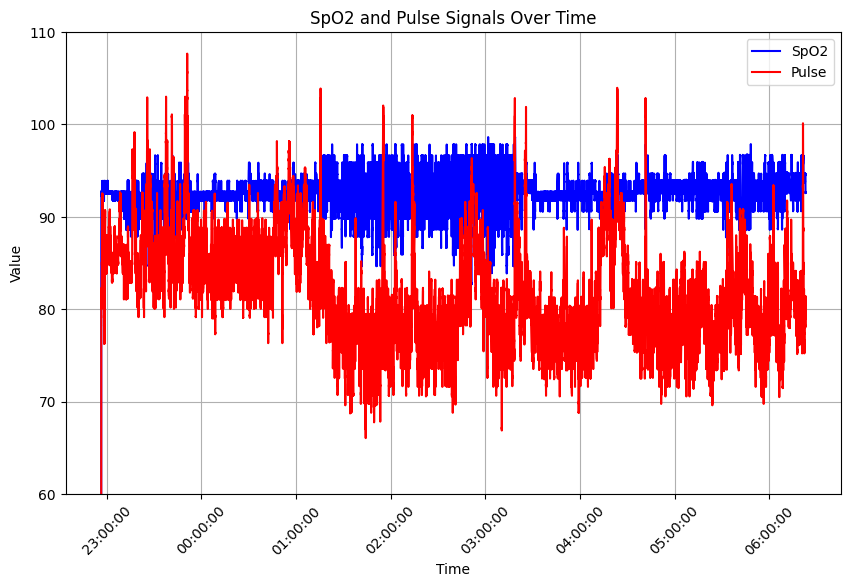

In [23]:
# @title Plot the signals from subject[XXX]_signals.csv { display-mode: "both" }
# Load CSV data into a DataFrame assuming the order of columns is timestamp, spo2, and pulse
df = pd.read_csv(csv_file)

# Assuming the columns are in order: date, time, spo2, and pulse
date = df['Date']
time = df['Time']
spo2 = df['SpO2']
pulse = df['Pulse']

# Combine date and time into a single string column 'Timestamp'
df['Timestamp'] = df['Date'] + ' ' + df['Time']

# Parse each datetime string into a datetime object
datetime_objects = []
for dt_str in df['Timestamp']:
    try:
        # Try parsing with milliseconds
        dt_obj = datetime.strptime(dt_str, "%Y-%m-%d %H:%M:%S.%f")
    except ValueError:
        # If milliseconds are not present, parse without milliseconds
        dt_obj = datetime.strptime(dt_str, "%Y-%m-%d %H:%M:%S")
    datetime_objects.append(dt_obj)


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(datetime_objects, df['SpO2'], label='SpO2', color='blue')
plt.plot(datetime_objects, df['Pulse'], label='Pulse', color='red')

plt.title('SpO2 and Pulse Signals Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
#plt.ylim(60, 110)
plt.grid(True)

# Set the format of the x-axis ticks to display only the time part
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

plot_png = "results/subject_plot" + subject + ".png"

# Save the plot to a file
plt.savefig(plot_png)

# Show the plot
plt.show()


                            OLS Regression Results                            
Dep. Variable:                  Pulse   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     716.8
Date:                Wed, 22 May 2024   Prob (F-statistic):          7.51e-156
Time:                        07:52:16   Log-Likelihood:                -84202.
No. Observations:               26791   AIC:                         1.684e+05
Df Residuals:                   26789   BIC:                         1.684e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         47.1864      1.291     36.563      0.0

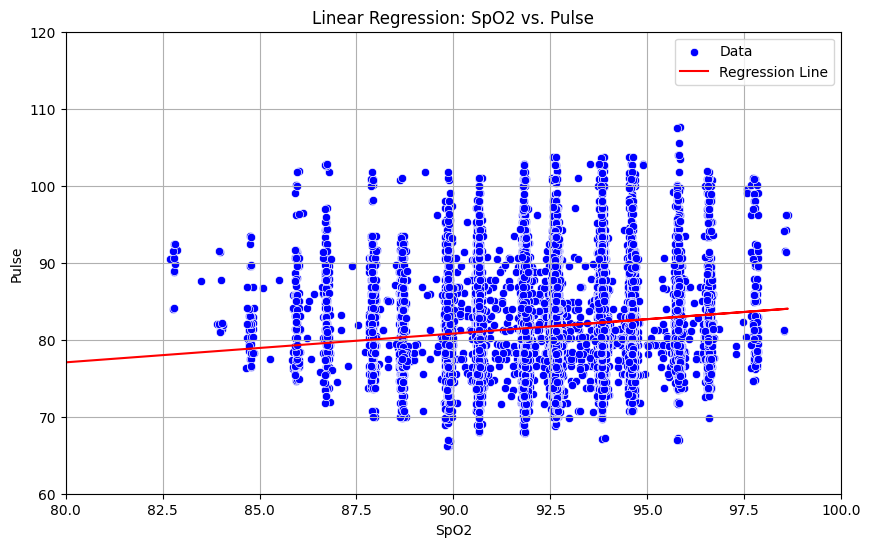

In [21]:
# @title make linear regression { display-mode: "both" }
import pandas as pd
import statsmodels.api as sm
import seaborn as sns

# Laden Sie Ihre Daten in ein DataFrame
df = pd.read_csv('combined_data.csv')

# Definieren Sie die unabhängige und abhängige Variable
X = df['SpO2']
y = df['Pulse']

# Fügen Sie einen konstanten Term zu den unabhängigen Variablen hinzu
X = sm.add_constant(X)

# Teilen Sie die Daten in Trainings- und Testsets auf (optional)
# train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Führen Sie die lineare Regression durch
model = sm.OLS(y, X).fit()

# Drucken Sie die Zusammenfassung des Modells
print(model.summary())


# Datenpunkte plotten
plt.figure(figsize=(10, 6))
sns.scatterplot(x='SpO2', y='Pulse', data=df, color='blue', label='Data')

# Regressionsgerade plotten
plt.plot(df['SpO2'], model.predict(X), color='red', label='Regression Line')

# Achsenbeschriftungen und Titel hinzufügen
plt.xlabel('SpO2')
plt.ylabel('Pulse')
plt.title('Linear Regression: SpO2 vs. Pulse')
plt.legend()
plt.grid(True)
plt.xlim(80, 100)
plt.ylim(60, 120)
# Diagramm anzeigen
plt.show()

In [24]:
# @title make Konfusionsmatrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Laden Sie Ihre Daten
df = pd.read_csv('combined_data.csv')

# Entfernen Sie NaN-Werte
#f_clean = df.dropna(subset=['Pulse', 'SpO2'])

# Unabhängige Variablen (X) und abhängige Variable (y) auswählen
X = df_clean[['Pulse', '0']]  # Umwandlung in eine DataFrame mit einer Spalte
y = df_clean['SpO2']

# Aufteilen der Daten in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature-Scaling durchführen
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistische Regression initialisieren und trainieren
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train_scaled, y_train)

# Vorhersagen mit dem trainierten Modell
y_pred = model.predict(X_test_scaled)

# Auswertung der Modellleistung
print(classification_report(y_test, y_pred))

# Konfusionsmatrix erstellen
conf_matrix = confusion_matrix(y_test, y_pred)

# Kategorien für die Achsenbeschriftung
categories = sorted(df_clean['Type'].unique())

# Diagramm erstellen
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=categories, yticklabels=categories)
plt.xlabel('Vorhersagte Werte')
plt.ylabel('Tatsächliche Werte')
plt.title('Konfusionsmatrix')
plt.show()


NameError: name 'df_clean' is not defined

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     APNEA-C       0.35      0.09      0.14       210
     APNEA-M       0.00      0.00      0.00        80
     APNEA-O       0.00      0.00      0.00       145
       HYP-C       0.26      0.69      0.38       298
       HYP-M       0.00      0.00      0.00        16
       HYP-O       0.31      0.38      0.34       251
          PB       0.00      0.00      0.00       145
    POSSIBLE       0.00      0.00      0.00         3

    accuracy                           0.28      1148
   macro avg       0.12      0.15      0.11      1148
weighted avg       0.20      0.28      0.20      1148



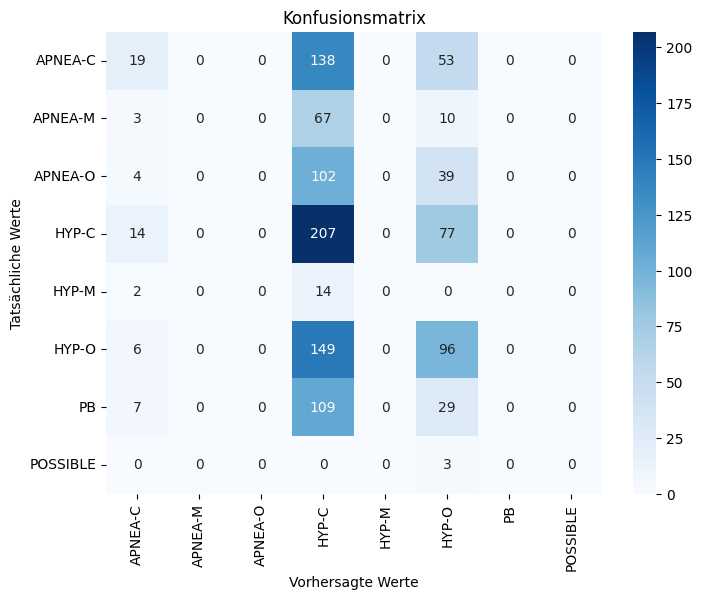

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Laden Sie Ihre Daten
df = pd.read_csv('combined_data.csv')

# Unabhängige Variablen (X) und abhängige Variable (y) auswählen
X = df[['Pulse', '0']]
y = df['Type']

# Entfernen von NaN-Werten aus den Trainingsdaten
df_clean = df.dropna(subset=['Pulse', '0', 'Type'])
X_clean = df_clean[['Pulse', '0']]
y_clean = df_clean['Type']

# Aufteilen der Daten in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# Feature-Scaling durchführen
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistische Regression initialisieren und trainieren
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train_scaled, y_train)

# Vorhersagen mit dem trainierten Modell
y_pred = model.predict(X_test_scaled)

# Auswertung der Modellleistung
print(classification_report(y_test, y_pred))

# Konfusionsmatrix erstellen
conf_matrix = confusion_matrix(y_test, y_pred)

# Kategorien für die Achsenbeschriftung
categories = sorted(df_clean['Type'].unique())

# Diagramm erstellen
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=categories, yticklabels=categories)
plt.xlabel('Vorhersagte Werte')
plt.ylabel('Tatsächliche Werte')
plt.title('Konfusionsmatrix')
plt.show()


In [ ]:
# @title create Korrelationsmatrix - funktioniert nicht!!!

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Laden Sie Ihre Daten
df = pd.read_csv('combined_data.csv')

# Überprüfen Sie, ob die Spalte 'Type' fehlende Werte enthält
missing_values = df['Type'].isnull().sum()

# Wenn es fehlende Werte gibt, entfernen Sie die entsprechenden Zeilen
if missing_values > 0:
    df.dropna(subset=['Type'], inplace=True)

# Konvertieren Sie kategoriale Variablen in numerische mit One-Hot-Encoding
df_encoded = pd.get_dummies(df)

# Berechnen Sie die Korrelationsmatrix für alle numerischen Spalten
corr_matrix = df_encoded.corr()

# Erstellen Sie ein Heatmap-Diagramm für die Korrelationsmatrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True)
plt.title('Korrelationsmatrix')
plt.show()